In [ ]:
# Basic dependencies

import os 
import os.path
import io 
import traceback
from absl import app
from absl import flags

import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import yaml
from PIL import Image
from easydict import EasyDict as edict

os.environ['OPENAI_API_KEY'] = 'sk-proj-\-NokGDdVyTJTx6CFKJy6yQtwmqHBwNdUYjJyWou2mjWagQRV0C2gEPlyJFqXEtmI6ZSp8sXi9CT3BlbkFJr9ZI4ck02lQLW0TL6MOIDCOzBA2yZS-MAS_onNDAun97YIepLWHJThnLMQrWQ_ISIQKHt9ix4A' # put your key here

In [57]:
# MOKA utilities

from string import ascii_lowercase

from openai import OpenAI
client = OpenAI()


from moka.gpt_utils import request_gpt
from moka.vision.segmentation import get_scene_object_bboxes
from moka.vision.segmentation import get_segmentation_masks
from moka.vision.keypoint import get_keypoints_from_segmentation
from moka.planners.planner import Planner
from moka.planners.visual_prompt_utils import *

In [58]:
import os
config_filename = './config/moka.yaml'
with open(config_filename, 'r') as fh:
    config = yaml.load(fh, Loader=yaml.SafeLoader)
    config = edict(config)

In [59]:
def load_prompts():
    """Load prompts from files.
    """
    prompts = dict()
    prompt_dir = os.path.join(
        config.prompt_root_dir, config.prompt_name)
    for filename in os.listdir(prompt_dir):
        path = os.path.join(prompt_dir, filename)
        if os.path.isfile(path) and path[-4:] == '.txt':
            with open(path, 'r') as f:
                value = f.read()
            key = filename[:-4]
            prompts[key] = value
    return prompts
    
prompts = load_prompts()
print(prompts)

{'filter_subtasks': "Postprocess the list of subtasks. \n\nThe input request contains:\n    - A string describes the multi-stage task.\n    - The subtask information is a list of dictionaries in the JSON form. Each dictionary specifies the information of a subtask, following the correct order of executing the subtasks to solve the input task. Each dictionary contains these fields: \n        * 'instruction': The task in natural language forms.\n        * 'object_grasped': The object that the robot gripper will hold in hand while executing the task. Please output '' if no object matched.\n        * 'object_unattached': The object that the robot gripper will interact with either directly or via another object, and not holding it in hand. Please output '' if no object matched.\n        * 'motion_direction': The motion direction of the robot gripper or the in-hand object while performing the task.\n\nThe output response follows the same format of the input subtask information as a list of d

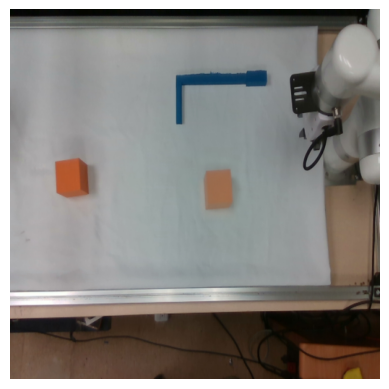

Task:  get the orange cube to the transparent target.


In [60]:
obs_image = Image.open('tool.jpeg').convert('RGB')
obs_image = obs_image.resize([512, 512], Image.LANCZOS)

obs = {'image': obs_image}
plt.imshow(obs_image)
plt.axis('off')
plt.show()

task_instruction = 'get the orange cube to the transparent target.'
print('Task: ', task_instruction)

In [61]:
plan = request_plan(
    task_instruction,
    obs_image, 
    plan_with_obs_image=config.plan_with_obs_image,
    prompts=prompts,
    debug=True)

# Example response after filtering

# res = """
# [
#     {
#         "instruction": "Move the metal watch into the ultrasound cleaner.",
#         "object_grasped": "metal watch",
#         "object_unattached": "white ultrasound cleaner",
#         "motion_direction": "downward"
#     },
#     {
#         "instruction": "Press the red button to turn on the ultrasound cleaner.",
#         "object_grasped": "",
#         "object_unattached": "red button",
#         "motion_direction": "downward"
#     }
# ]
# """

# object_info = json.loads(res)
# plan = object_info
print(plan)

--------------------------------
| Generated plan.
--------------------------------
```json
[
    {
        "instruction": "Pick up the orange cube.",
        "object_grasped": "orange cube",
        "object_unattached": "",
        "motion_direction": ""
    },
    {
        "instruction": "Move the orange cube to the transparent target.",
        "object_grasped": "orange cube",
        "object_unattached": "transparent target",
        "motion_direction": "right"
    }
]
```
--------------------------------
| Filtered plan.
--------------------------------
```json
[
    {
        "instruction": "Move the orange cube to the transparent target.",
        "object_grasped": "orange cube",
        "object_unattached": "transparent target",
        "motion_direction": "right"
    }
]
```
[{'instruction': 'Move the orange cube to the transparent target.', 'object_grasped': 'orange cube', 'object_unattached': 'transparent target', 'motion_direction': 'right'}]


In [62]:
all_object_names = []
for subtask in plan:
    if subtask['object_grasped'] != '' and subtask['object_grasped'] not in all_object_names:
        all_object_names.append(subtask['object_grasped'])

    if subtask['object_unattached'] != '' and subtask['object_unattached'] not in all_object_names:
        all_object_names.append(subtask['object_unattached'])

print(all_object_names)

['orange cube', 'transparent target']


./ckpts/groundingdino_swint_ogc.pth ; exist: True
final text_encoder_type: bert-base-uncased


/home/zhujinxuan/anaconda3/envs/moka/lib/python3.10/site-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/zhujinxuan/anaconda3/envs/moka/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/zhujinxuan/anaconda3/envs/moka/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


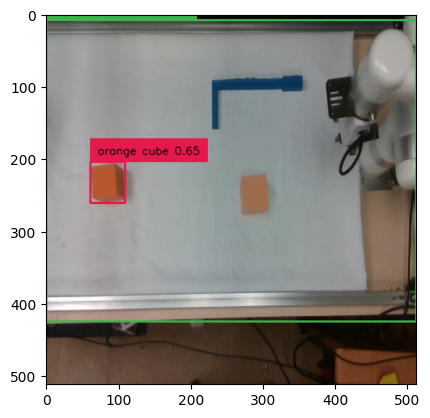

In [63]:
# get bounding boxes
boxes, logits, phrases = get_scene_object_bboxes(
                obs_image, all_object_names,
                visualize=True,
                logdir=None)

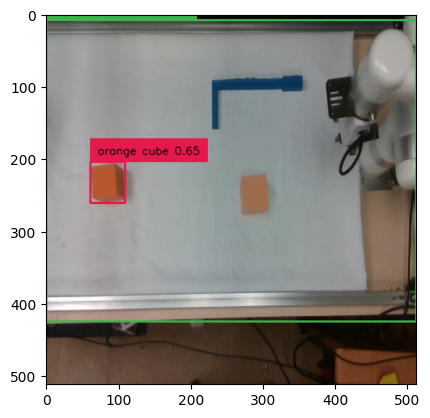

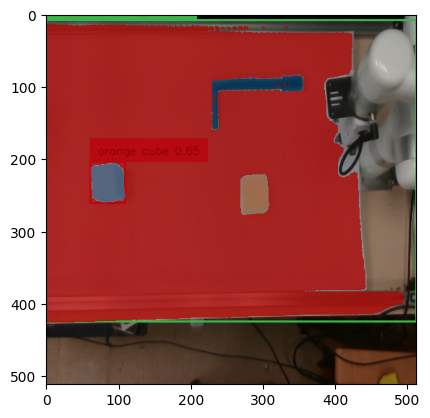

In [64]:
# Get segmentation masks
segmasks = get_segmentation_masks(obs_image, all_object_names, boxes, logits, phrases, visualize=True)

image_size (annotate_candidate_keypoints) (512, 512)


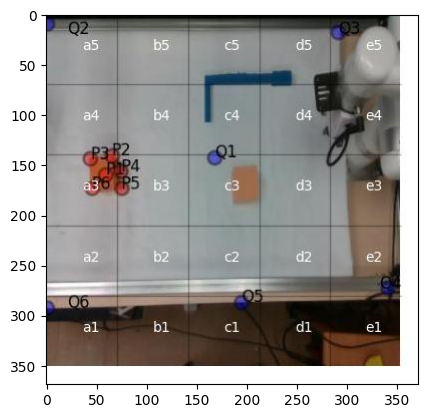

In [65]:
# Annotate visual marks.
subtask = plan[0]
candidate_keypoints = propose_candidate_keypoints(
    subtask,
    segmasks, 
    num_samples=config.num_candidate_keypoints)

annotation_size = next(iter(segmasks.values()))['mask'].shape[:2][::-1] 
obs_image_reshaped = obs_image.resize(annotation_size, Image.LANCZOS)

annotated_image = annotate_visual_prompts(
            obs_image,
            candidate_keypoints,
            waypoint_grid_size=config.waypoint_grid_size)

--------------------------------
| Selected motion.
--------------------------------
To execute the task of moving the orange cube to the transparent target, we need to determine the appropriate keypoints and waypoints based on the given inputs.

1. **Grasp Keypoint:**
   - The orange cube has candidate keypoints P4 and P5.
   - Choose **P4** as it appears central for a stable grasp.

2. **Function Keypoint:**
   - Since the task is pick-and-place, the function keypoint will be the same as the grasp keypoint. Use **P4**.

3. **Target Keypoint:**
   - The task involves moving towards the transparent target, represented by **Q1**.

4. **Target Tile:**
   - The transparent target (Q1) is located in tile **c3**.

5. **Pre-contact Tile:**
   - Prior to making contact, move the object near its destination. Use tile **b3** as a staging point.

6. **Post-contact Tile:**
   - After placing the object, move slightly away to tile **d3**.

7. **Pre-contact Height and Post-contact Height:**
   - Si

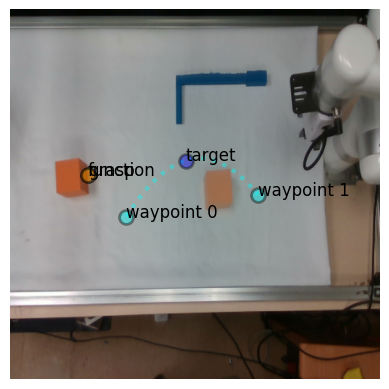

In [66]:
# Select motion 
# The json format given by GPT4-O can be incorrect. If it fails to visualize the image, please check whether the context is correctly parsed 

from moka.planners.visual_prompt_utils import request_motion

context, _, _ = request_motion(
            subtask,
            obs_image,
            annotated_image,
            candidate_keypoints,
            waypoint_grid_size=config.waypoint_grid_size, 
            prompts=prompts, 
            debug=True
    )